In [1]:
import cupy as cp
import numpy as np
import matplotlib.pyplot as plt
from HDF5DatasetGenerator import HDF5DatasetGenerator
import mlflow 
import torch
import torch.nn as nn

In [2]:
G = mlflow.pytorch.load_model('/home/przemek/Desktop/engineering-thesis/mlruns/8/19f9ab6b709f4f9083cb7680174cda1c/artifacts/Ge_step_75000')
print(G)

Generator(
  (fc): Sequential(
    (0): Linear(in_features=10, out_features=1024, bias=True)
    (1): ReLU()
    (2): Linear(in_features=1024, out_features=1024, bias=True)
    (3): ReLU()
    (4): Linear(in_features=1024, out_features=1024, bias=True)
    (5): ReLU()
    (6): Linear(in_features=1024, out_features=1024, bias=True)
    (7): Sigmoid()
    (8): Linear(in_features=1024, out_features=6, bias=True)
  )
)


In [3]:
def join_p(x,xp):
    return torch.cat([x,xp.repeat(x.shape[0],1)],1)

DEVICE = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
batch_size = int(5e4)
n_noise = 6
for i in range(int(2e6/batch_size)):
    _x = torch.randn(batch_size, n_noise).to(DEVICE)
    xp = np.array([1.0,2.0,0.4,0.4],dtype=np.float32).reshape((1,-1))
    xp = torch.tensor(xp).to(DEVICE)
    x = join_p(_x,xp)
    generated_data_part = G(x).detach().to('cpu').numpy()
    if i==0:
        generated_data = generated_data_part
    else:
        generated_data = np.concatenate([generated_data,generated_data_part],axis=0)

In [4]:
del G, x
torch.cuda.empty_cache()

In [5]:
generated_data = cp.array(generated_data)

In [6]:
generator = HDF5DatasetGenerator('../data/structured/DISP_1_ANGLE_2/c4TrainGenerator.hdf5',int(2e6))

In [7]:
data = cp.array(next(generator.generator()))

In [8]:
keys = ['E', 'X', 'Y', 'dX', 'dY', 'dZ']

In [9]:
import itertools
def powerset(iterable):
    "powerset([1,2,3]) --> () (1,) (2,) (3,) (1,2) (1,3) (2,3) (1,2,3)"
    s = list(iterable)
    return itertools.chain.from_iterable(itertools.combinations(s, r) for r in range(len(s)+1))

In [10]:
comb = [x for x in powerset([0,1,2,3,4,5]) if len(x)==2]
len(comb)

15

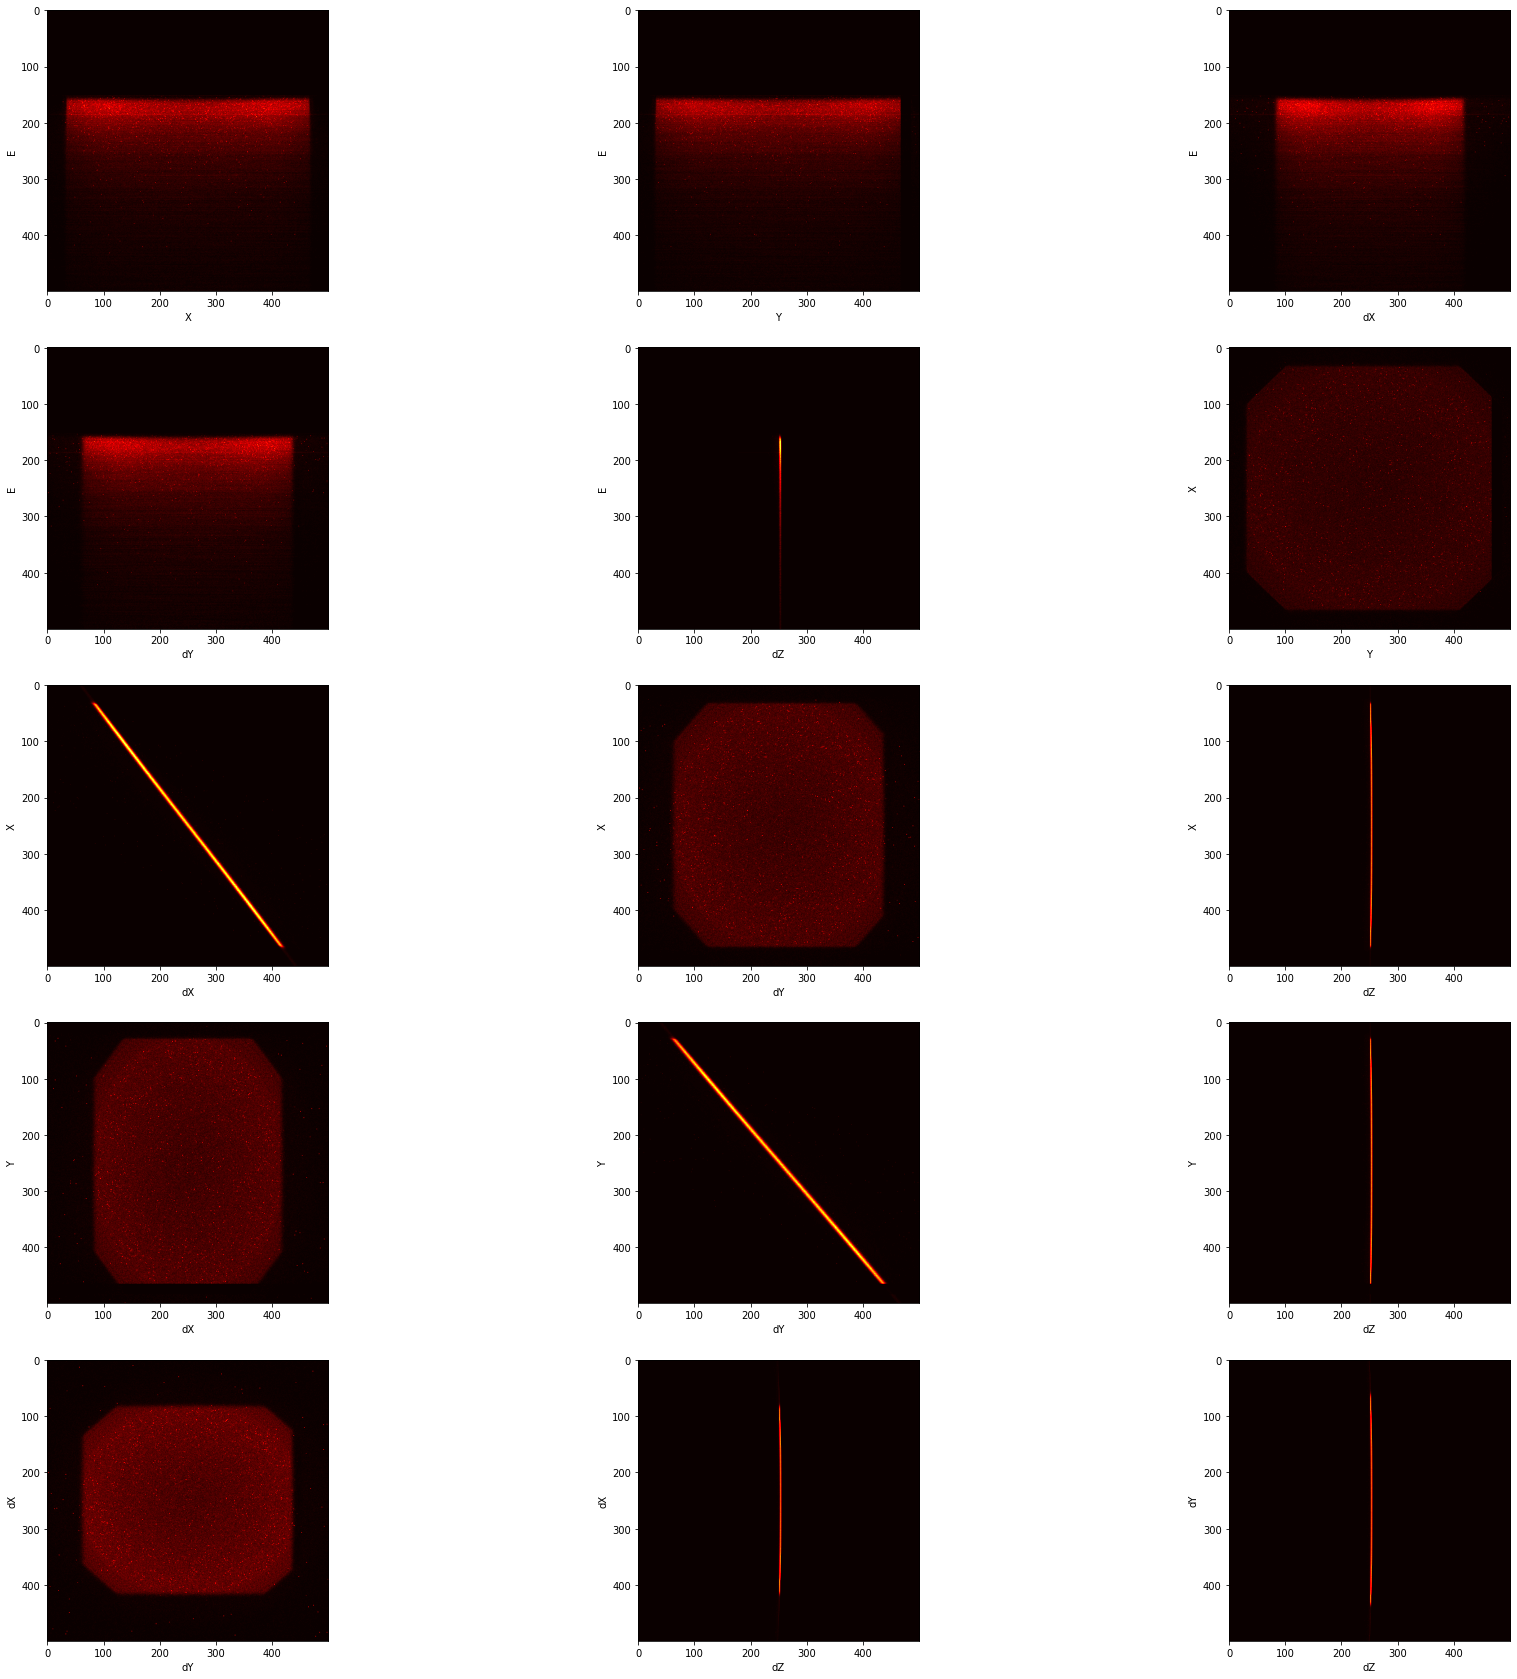

In [11]:
fig,axs = plt.subplots(5,3)
fig.set_size_inches((30,30))
for k,(i,j) in enumerate(comb):
    temp = cp.histogramdd(data[:,[i,j]],bins=[500,500],range=[[-2,2],[-2,2]],density=True)
    temp_im = temp[0]
    axs.flatten()[k].imshow(temp_im.get(),cmap='hot')
    axs.flatten()[k].set_ylabel(keys[i])
    axs.flatten()[k].set_xlabel(keys[j])

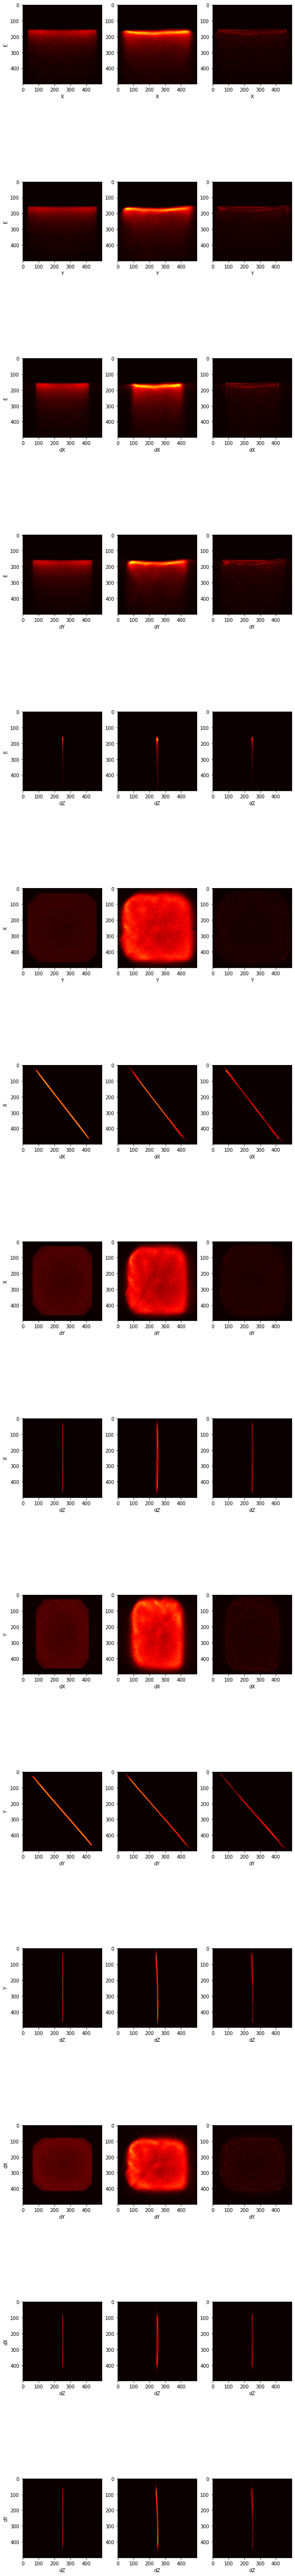

In [12]:
fig,axs = plt.subplots(15,3)
fig.set_size_inches((10,100))
for it,(i,j) in enumerate(comb):
    k = it*3
    temp_t = cp.histogramdd(data[:,[i,j]],bins=[500,500],range=[[-2,2],[-2,2]],density=True)
    axs.flatten()[k].imshow(temp_t[0].get(),cmap='hot')
    axs.flatten()[k].set_ylabel(keys[i])
    axs.flatten()[k].set_xlabel(keys[j])
    temp_f = cp.histogramdd(generated_data[:,[i,j]],bins=[500,500],range=[[-2,2],[-2,2]],density=True)
    axs.flatten()[k+1].imshow(temp_f[0].get(),cmap='hot')
    axs.flatten()[k+1].set_ylabel(keys[i])
    axs.flatten()[k+1].set_xlabel(keys[j])
    
    axs.flatten()[k+2].imshow((cp.abs(temp_f[0]-temp_t[0])).get(),cmap='hot')
    axs.flatten()[k+2].set_ylabel(keys[i])
    axs.flatten()[k+2].set_xlabel(keys[j])

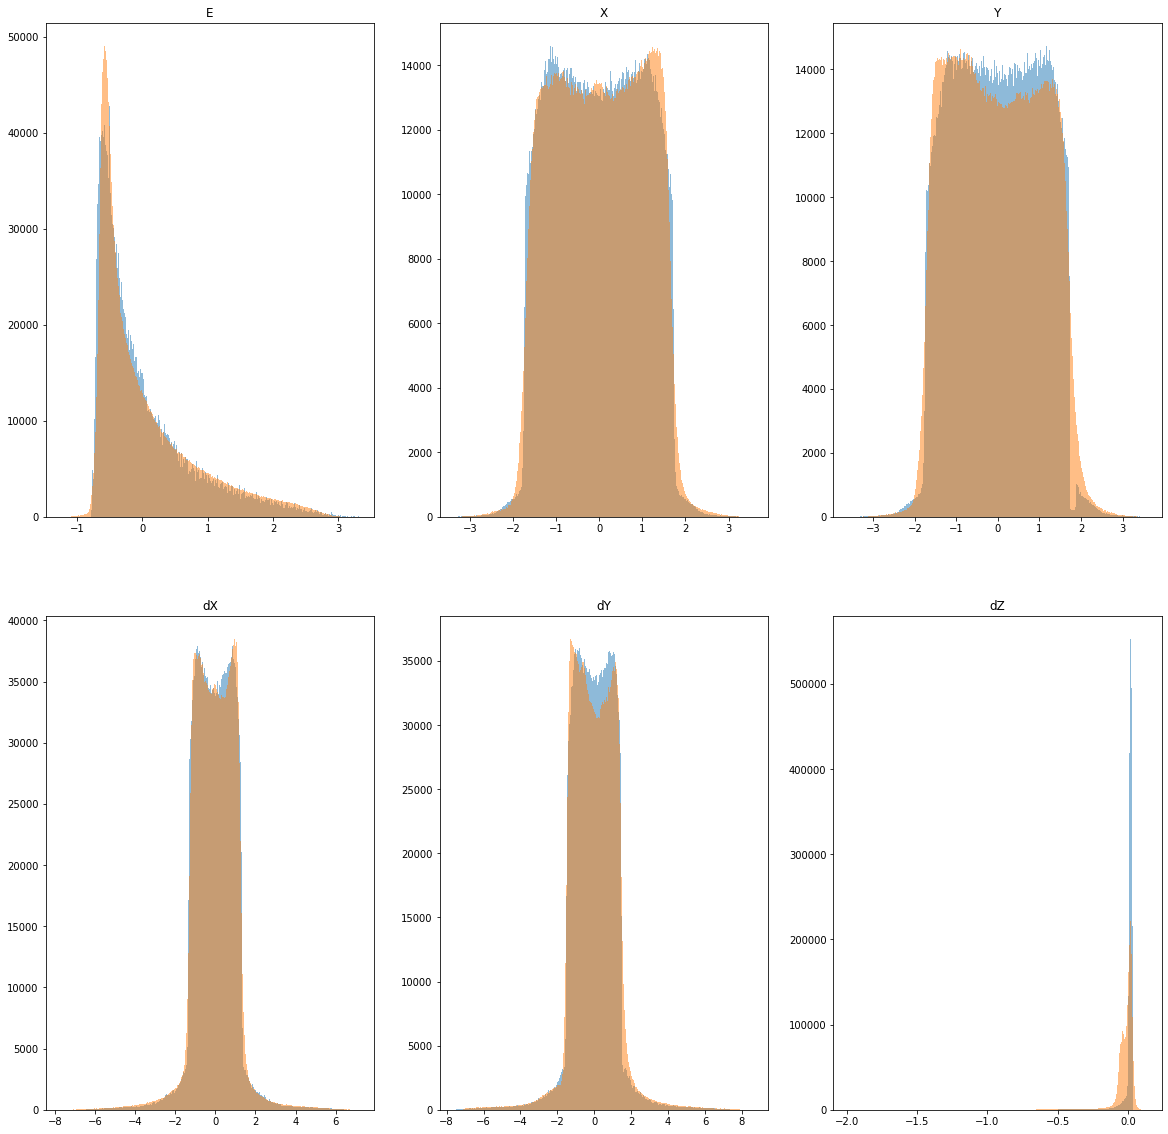

In [13]:
fig, axs = plt.subplots(2, 3)
fig.set_size_inches(20, 20)
for i, j in enumerate(keys):
    mi = np.minimum(data[:, i].min().get(), generated_data[:, i].min().get())
    ma = np.maximum(data[:, i].max().get(), generated_data[:, i].max().get())
    bins = np.linspace(mi, ma, 300)
    axs.flatten()[i].hist(data[:, i].get(), bins, alpha=.5)
    axs.flatten()[i].hist(generated_data[:, i].get(), bins, alpha=.5)
    axs.flatten()[i].set_title(j)